# Time series forecasting fundamentals with Tensorflow
**Project:** BitPredict 💰 Using TensorFlow to predict the price of Bitcoin based on the historical price of BitCoin

**Note:** This is not financial advice. Just to learn how to adapt deep learning to predict time series

**Resource:** 
- https://otexts.com/fpp3/a-tidy-forecasting-workflow.html

## Preparation:

### Get the data and prepare

In [1]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2022-07-13 13:49:18--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2022-07-13 13:49:18 (11.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



In [2]:
import pandas as pd

df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"])

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


## Inspect the data 👀

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [4]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [5]:
print(f"Number of samples we have: {len(df)}")

Number of samples we have: 2787


**🔑 Quick Note**

The data we have of the historical price of Bitcoin for the past 8 years are only 2787 samples.

Typically deep learning models usually like lots and lots of samples.

A small number of samples is something you'll often run into with time series data problems.

In [6]:
# Only wawnt closing price for each day
bitcoin_prices = bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


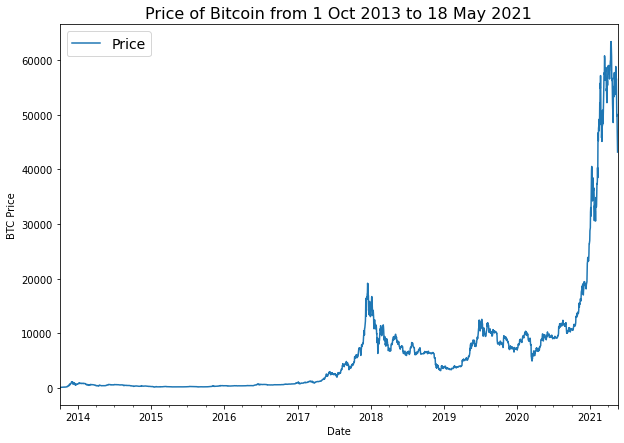

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10,7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)

## Create train and test datasets

In [8]:
# Check the first 5
bitcoin_prices.iloc[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

**Note❗️**

We can't do normal split because we're focusing on time series predict so we need to do time-series split.

Resource: [Scikit-learn, Time-Series split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html)

In [10]:
# Create train and test splits
split_size = int(0.8* len(prices))

x_train, y_train = timesteps[:split_size], prices[:split_size]

x_test, y_test = timesteps[split_size:], prices[split_size:]

In [11]:
x_train

array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
       '2013-10-03T00:00:00.000000000', ...,
       '2019-11-05T00:00:00.000000000', '2019-11-06T00:00:00.000000000',
       '2019-11-07T00:00:00.000000000'], dtype='datetime64[ns]')

### Scatter plot function 

In [12]:
# Plot the split
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.xlabel("BTC Price")
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

  # plt.scatter(x_train, y_train, s=5, label="train_data")
  # plt.scatter(x_test, y_test, s=5, label="test_data")
  # plt.xlabel("Days")
  # plt.ylabel("BTC Price")
  # plt.legend(fontsize=14)
  # plt.show()  

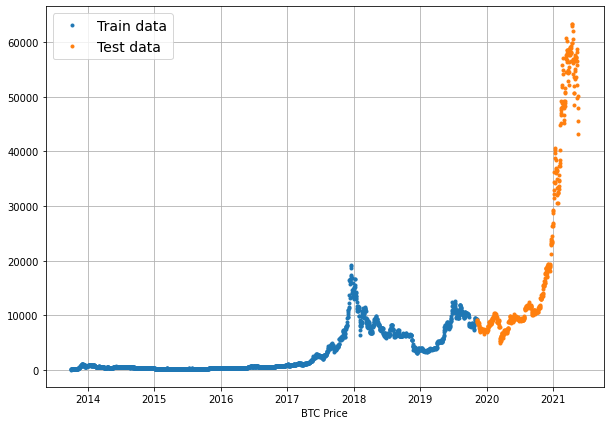

In [13]:
# Test out plotting function
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")

# Modeling Experiments

Experiments Model We will create.
- Model 0: Naive model (baseline)
- Model 1: Dense Model
- Model 2: Same as model 1
- Model 3: Same as model 1
- Model 4: Conv1D
- Model 5: LSTM
- Model 6: Same as model 1 (but with multivariate data)
- Model 7: N-BEATS algorithm
- Model 8: Ensemble (multiple models stacked together)
- Model 9: Future prediction model
- Model 10: Same as model 1 (but with turkey data introduced)


## Model 0: Naive Forecast (baseline)

The formula looks like: $$\hat{y}_{t} = y_{t-1}$$

The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - **this is for horizon of 1**

In [14]:
# Create a naive forecast
naive_forecast = y_test[0:-1]
naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [15]:
len(x_test), len(naive_forecast)

(558, 557)

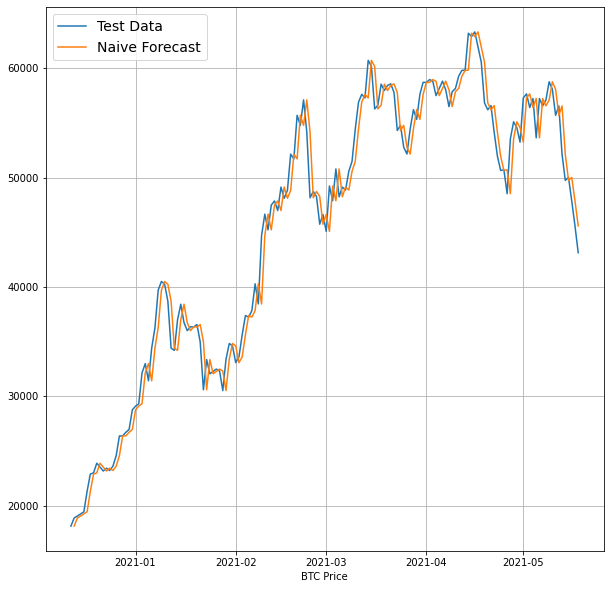

In [16]:
# Plot native forecast
plt.figure(figsize=(10,10))
# plot_time_series(timesteps=x_train, values=y_train, start=300, label="Train Data")
plot_time_series(timesteps=x_test, values=y_test, start=400, format="-", label="Test Data")
plot_time_series(timesteps=x_test[1:], values=naive_forecast, start=400, format="-", label="Naive Forecast")

### Evaluating a time series model 🧮 

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression metrics.

In [17]:
import tensorflow as tf

In [18]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (Focus on Non-Seasonal predict)
  """
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1]))

  return mae / mae_naive_no_season


Test MASE (this very should = 1 or be very close to 1 with naive forecast)


In [19]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

## Create evaluate function.

Create a function to take in model predictions and truth values then return evaluation.


In [20]:
def evaluate_preds(y_true, y_pred):
  # ❗️ Make sure float32 datatype (for metric calculations) sometime it stuck in datatype problems
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evalution metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse,0.5)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy(),}

Checking the function is work.

In [21]:
naive_results = evaluate_preds(y_true=y_test[1:],
                         y_pred=naive_forecast)

naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

# Format Data Part 2: Windowing our dataset

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```


In [22]:
# Setup global variables for windiw and horizon size
HORIZON = 1
WINDOW_SIZE = 7

In [23]:
# Create function to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.
  E.g. if horizon =1
  Input: [0, 1, 2, 3, 4, 5, 6] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [24]:
# Randomly Test ❌
print(tf.range(8)+1)
print(tf.expand_dims(tf.range(8)+1, axis=0))

# tf.expand_dims: https://www.tensorflow.org/api_docs/python/tf/expand_dims

tf.Tensor([1 2 3 4 5 6 7 8], shape=(8,), dtype=int32)
tf.Tensor([[1 2 3 4 5 6 7 8]], shape=(1, 8), dtype=int32)


In [25]:
# Test out the window labelling function
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
test_window, test_label

(<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6]], dtype=int32)>,
 <tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[7]], dtype=int32)>)

In [26]:
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


In [27]:
btc_price = bitcoin_prices['Price'].to_numpy()
btc_price[:20]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
       126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
       152.55183, 160.33883])

We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quiet slow.

To speed things up, we'll leverage NumPy's array indexing.

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use Numpy indexing to create a 2D array of multiple windows steps, for example:
```
[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8],.....
```

3. Uses the 2D array of multiple window steps (from 2.) to index a target series (e.g. the historical price of Bitcoin)
4. Use our `get_labelled_window()` function we created above to turn the window steps into windows with a specified horizon

In [28]:
test = btc_price.tolist() # Change btc_price to list

In [29]:
import numpy as np

# Create function to view NumPy array as windows
def make_windows(x, windows_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(windows_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(windows_size+horizon-1)),axis=0).T # create 2D array of window size and last block is to prevent go out of range
  # print(f"Window indexes:\n {window_indexes}, \n\nWindow indexes shape: {window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D arra of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)
  return windows, labels



In [30]:
# Test
full_windows, full_labels = make_windows(prices)
print(f"Full windows: \n{full_windows[0:10]} \n\nFull labels: \n{full_labels[0:10]}")
print("\n=======")
print(f"\nShape of full windows: {full_windows.shape}\nShape of full labels:{full_labels.shape}")

Full windows: 
[[123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]
 [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]
 [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]
 [118.67466 121.33866 120.65533 121.795   123.033   124.049   125.96116]
 [121.33866 120.65533 121.795   123.033   124.049   125.96116 125.27966]
 [120.65533 121.795   123.033   124.049   125.96116 125.27966 125.9275 ]
 [121.795   123.033   124.049   125.96116 125.27966 125.9275  126.38333]
 [123.033   124.049   125.96116 125.27966 125.9275  126.38333 135.24199]
 [124.049   125.96116 125.27966 125.9275  126.38333 135.24199 133.20333]
 [125.96116 125.27966 125.9275  126.38333 135.24199 133.20333 142.76333]] 

Full labels: 
[[123.033  ]
 [124.049  ]
 [125.96116]
 [125.27966]
 [125.9275 ]
 [126.38333]
 [135.24199]
 [133.20333]
 [142.76333]
 [137.92333]]


Shape of full windows: (2780, 7)
Shape of full labels:(2780, 1)


In [31]:
# Visualize the first 3 windows/labels
print("The first 3 windows/labels")
for i in range(3):
  print(f"Window: {full_windows[i]}  ->  Label: {full_labels[i]}\n")
print("=======")
print("\nThe last 3 windows/labels")
for i in range(3):
  print(f"Window: {full_windows[i-3]}  ->  Label: {full_labels[i-3]}")

The first 3 windows/labels
Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ]  ->  Label: [123.033]

Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ]  ->  Label: [124.049]

Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ]  ->  Label: [125.96116]


The last 3 windows/labels
Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676]  ->  Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472]  ->  Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361]  ->  Label: [43144.47129086]


🔑 **Note:** There's a function which does similar, Check this link: [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array)

# Turning windows into training and test sets

In [32]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [33]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will make train to 80%
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels


In [34]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(full_windows), len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2780, 2224, 556, 2224, 556)

In [35]:
train_windows.shape, train_labels.shape

((2224, 7), (2224, 1))

In [36]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

# Make a modelling checkpoint 📍

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More speicfically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs) , we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following:
[Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint)



In [37]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename.
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            monitor="val_loss",
                                            verbose=0, # Only output a limited amount of text
                                            save_best_only=True)

# Continue creating a model

## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs - because the number of the data is small

In [38]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# # 1. Construct model ---Only Test---
# inputs = layers.Input(shape=len(train_windows[0]))
# x = layers.Dense(128, activation="relu")(inputs),
# outputs = layers.Dense(HORIZON, activation="linear")(inputs)
# model_1 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_1_dense")

model_1 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON, activation="linear")],
                              name="model_1_dense")

# 2. Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae","mse"])

# 3. Fit the model
model_1.fit(x=train_windows,
            y=train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)])


Epoch 1/100
18/18 [==============================] - 7s 121ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
Epoch 2/100
18/18 [==============================] - 1s 50ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9992 - val_mae: 1005.9992 - val_mse: 3441833.5000
Epoch 3/100
18/18 [==============================] - 1s 46ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.5938 - val_loss: 923.2863 - val_mae: 923.2863 - val_mse: 2868221.2500
Epoch 4/100
18/18 [==============================] - 1s 62ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5625 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.7500
Epoch 5/100
18/18 [==============================] - 1s 42ms/step - loss: 165.0895 - mae: 165.0895 - mse: 145490.8125 - val_loss: 895.2236 - val_mae: 895.2236 - val_mse: 2564574.5000
Epoch 6/100
18/18 [==============================] - 1s 57ms/step - loss: 158.

### Make prediction and evaluate

In [39]:
# Evaluate the model
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9753 - mae: 585.9753 - mse: 1197801.2500


[585.9752807617188, 585.9752807617188, 1197801.25]

In [40]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171744.0000


[568.9510498046875, 568.9510498046875, 1171744.0]

In [41]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

### Making forecasts with a model (on the test dataset)

To make "forecasts" on the test dataset (note: these won't be actial forecasts, they're only pseudo forecasts becaise actia; forecasts are into the future).

1. Take in a train model
2. Take in some inputs data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [42]:
def make_preds(model, input_data):
  """
  Uses model to make predictions input_data,
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [43]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
print(f"Shape of model 1 predict: {model_1_preds.shape}, \n\nModel 1 prediction:\n{model_1_preds[:10]}")

Shape of model 1 predict: (556,), 

Model 1 prediction:
[8861.713  8769.888  9015.712  8795.52   8723.8125 8730.111  8691.953
 8502.056  8460.962  8516.548 ]


In [44]:
model_1_results = evaluate_preds(y_true=test_labels, y_pred=model_1_preds)
model_1_results

{'mae': array([11928.929 , 11795.891 , 11974.977 , 11948.295 , 11954.37  ,
        12005.419 , 12095.949 , 12114.574 , 12074.432 , 12274.319 ,
        12328.178 , 12355.67  , 12659.423 , 12910.017 , 12878.645 ,
        13093.805 , 12949.455 , 13008.3125, 12720.619 , 12814.962 ,
        12581.032 , 12707.599 , 12820.863 , 12856.264 , 12869.688 ,
        12947.94  , 12808.82  , 12728.707 , 12714.619 , 12702.064 ,
        12856.512 , 12927.328 , 12960.66  , 12967.023 , 12928.019 ,
        13054.392 , 13032.358 , 13233.182 , 13509.829 , 12790.82  ,
        13002.82  , 13009.273 , 12891.54  , 12929.485 , 12987.106 ,
        12930.547 , 12948.688 , 12972.473 , 12937.096 , 12872.538 ,
        12818.357 , 12918.381 , 12975.588 , 12979.921 , 13169.249 ,
        12887.851 , 12853.18  , 12845.99  , 12591.284 , 12378.13  ,
        12360.252 , 12528.333 , 12347.6875, 12353.043 , 12309.107 ,
        12329.122 , 11962.128 , 11905.701 , 11974.921 , 11866.165 ,
        11859.349 , 12016.113 , 12007.855

Shape on the upper blog is not the same so it gives different results from what we expected.

In [45]:
# Shape is not the same so we need to change it
test_labels.shape, model_1_preds.shape
tf.squeeze(test_labels).shape, model_1_preds.shape


(TensorShape([556]), TensorShape([556]))

In [46]:
# Squeeze the test_labels to make it the same
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171744.0,
 'rmse': 1082.4712}

In [47]:
# Compare with naive_results
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

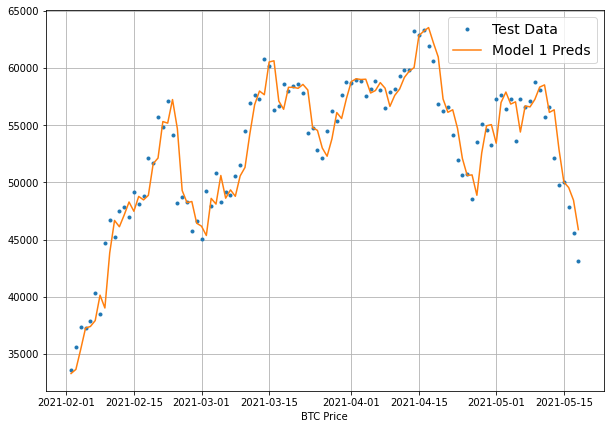

In [48]:
# Plot model 1 predictions
OFFSET=450
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=OFFSET, label="Test Data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_1_preds, format="-", start=OFFSET, label="Model 1 Preds")

## Model 2: Dense (window = 30, horizon = 1)

In [49]:
# Set parameters
HORIZON = 1 # predict one step at a time
WINDOW_SIZE = 30 # use 30 timesteps in apast

In [50]:
# Make windows data with appropriate horizon and window sizes
full_windows, full_labels= make_windows(prices, windows_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [51]:
# Make train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [52]:
train_windows[0:3], train_labels[0:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [53]:
tf.random.set_seed(42)

# Create model
model_2 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_2_dense")

# Compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

### Make prediction and evaluate

In [54]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9620


608.9619750976562

In [55]:
# Load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9620


608.9619750976562

In [56]:
# Get forecast predictions
model_2_preds = make_preds(model_2,
                           input_data=test_windows)

In [57]:
#E Evaluate results for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)
model_2_results

{'mae': 608.962,
 'mape': 2.7693412,
 'mase': 1.0644715,
 'mse': 1281440.6,
 'rmse': 1132.0073}

In [58]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171744.0,
 'rmse': 1082.4712}

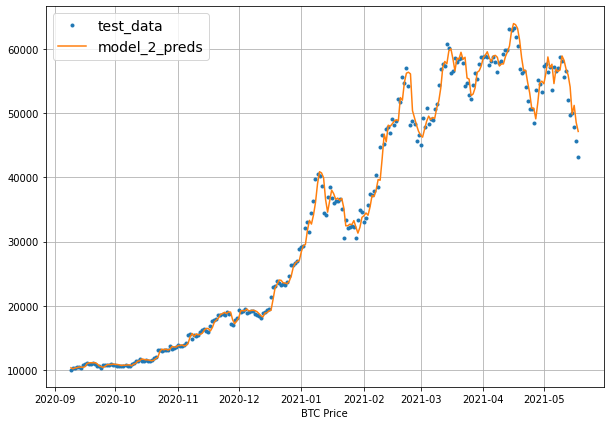

In [59]:
OFFSET = 300
plt.figure(figsize=(10,7))
# Account for test window offset when plotting
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=OFFSET, label="test_data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_2_preds, start=OFFSET, format="-", label="model_2_preds")

## Model 3: Demse (window = 30, horizon = 7)

In [60]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, windows_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [61]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [62]:
tf.random.set_seed(42)

# Create model (same as model_1 except with different data input and output)
model_3 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_3_dense")

# Compile
model_3.compile(loss="MAE",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

### Make prediction and evaluate

In [63]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1340.4272


1340.42724609375

In [64]:
# Load in the best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1234.8838


1234.8837890625

In [65]:
# Get forecast predictions
model_3_preds = make_preds(model_3,
                           input_data=test_windows)

In [66]:
model_3_preds.shape, test_labels.shape

(TensorShape([551, 7]), (551, 7))

In [67]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': array([  561.22516 ,   301.9714  ,   297.9477  ,   413.84305 ,
          445.20914 ,   540.59717 ,   527.22864 ,   441.84564 ,
          498.77365 ,   639.1921  ,   803.132   ,   731.72614 ,
          678.6172  ,   797.18567 ,   575.3339  ,   280.21136 ,
          239.9216  ,   246.152   ,   276.387   ,   285.75482 ,
          118.80413 ,   135.45549 ,   191.11852 ,   251.82576 ,
          170.28934 ,   154.20027 ,   107.244835,    97.66267 ,
          111.26416 ,   139.85393 ,   269.1739  ,   369.812   ,
          270.48096 ,   263.1211  ,   247.72252 ,   255.50523 ,
          298.48172 ,   245.26395 ,   243.13072 ,   255.7583  ,
          416.6257  ,   150.97021 ,    94.16581 ,   101.62012 ,
           93.76974 ,    86.75328 ,    73.27923 ,    79.04513 ,
           89.541084,    93.11977 ,   106.798546,   141.09578 ,
          178.73668 ,   145.46994 ,   256.4566  ,   392.8164  ,
          560.91174 ,   552.8188  ,   536.1548  ,   535.2687  ,
          448.70444 ,   267.23312

### Make our evaluation function work for larger horizons

In [68]:
def evaluate_preds(y_true, y_pred):
  # ❗️ Make sure float32 datatype (for metric calculations) sometime it stuck in datatype problems
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evalution metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse,0.5)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    maps = tf.reduce_mean(mase)


  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy(),}

In [69]:
# Evaluate results for model 3 predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1234.8837,
 'mape': 5.4874983,
 'mase': 2.1974063,
 'mse': 5393734.0,
 'rmse': 1419.1362}

In [70]:
model_2_results

{'mae': 608.962,
 'mape': 2.7693412,
 'mase': 1.0644715,
 'mse': 1281440.6,
 'rmse': 1132.0073}

### Visualize Model 3

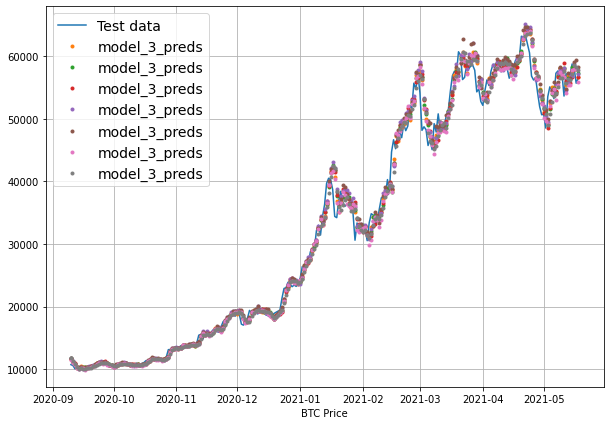

In [71]:
OFFSET = 300
plt.figure(figsize=(10,7))
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], format="-", start=OFFSET, label="Test data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=model_3_preds,  start=OFFSET, label="model_3_preds")

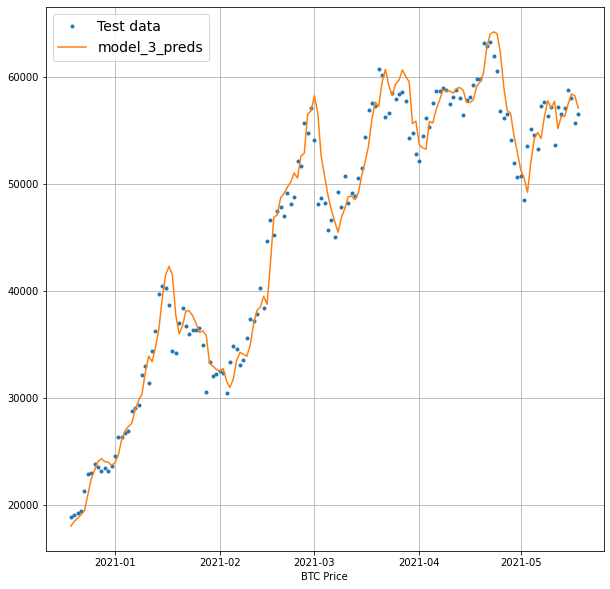

In [72]:
# We need to reduce_mean first
OFFSET = 400
plt.figure(figsize=(10,10))
plot_time_series(timesteps=x_test[-len(test_windows):], values=test_labels[:, 0], start=OFFSET, label="Test data")
plot_time_series(timesteps=x_test[-len(test_windows):], values=tf.reduce_mean(model_3_preds, axis=1), start=OFFSET, format="-",  label="model_3_preds")

# Comparing between our models

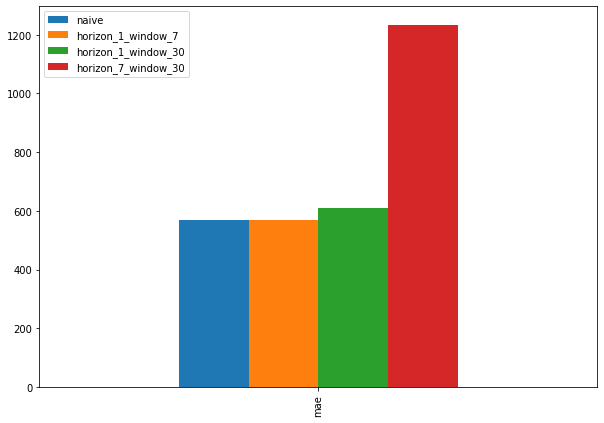

In [73]:
pd.DataFrame({"naive": naive_results["mae"],
             "horizon_1_window_7": model_1_results["mae"],
             "horizon_1_window_30": model_2_results["mae"],
             "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10,7), kind="bar")

## Model 4: Conv1D

### Preparation to create Conv1D model

In [74]:
HORIZON = 1
WINDOW_SIZE = 7

In [75]:
# Create windowed data
full_windows, full_labels = make_windows(prices, windows_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [76]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

In [77]:
# Check data input shape
train_windows[0].shape

(7,)

In [78]:
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [79]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension
expand_dims_layer

In [80]:
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expaned shape: {expand_dims_layer(x).shape}")
print(f"Original value with expanded shape:\n {expand_dims_layer(x)}")

Original shape: (7,)
Expaned shape: (7, 1)
Original value with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


### Model creation

In [81]:
# Create Conv1D model
model_4 = tf.keras.Sequential([
                               layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
                               layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
                               layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile the model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(train_windows, train_labels,
            batch_size=128,
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
INFO:tensorflow:Assets wr

In [82]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [83]:
# Output shape is difference from model_2 so we need to change
model_2.summary()

Model: "model_2_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 128)               3968      
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 4,097
Trainable params: 4,097
Non-trainable params: 0
_________________________________________________________________


### Make prediction and evaluate

In [84]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 11ms/step - loss: 630.4090


630.4089965820312

In [85]:
# Load in the best performing model
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D/")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 569.6168


569.6168212890625

In [86]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[0:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8910.764, 8808.881, 9009.131, 8804.39 , 8759.231, 8738.197,
       8705.465, 8556.177, 8469.611, 8534.404], dtype=float32)>

In [87]:
# Evaluate prediction
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results

{'mae': 569.6168,
 'mape': 2.5637593,
 'mase': 1.000659,
 'mse': 1185833.0,
 'rmse': 1088.9596}

In [88]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171744.0,
 'rmse': 1082.4712}

## Model 5: RNN(LSTM)

In [89]:
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
x = layers.LSTM(128, return_sequences=True, activation="relu")(x)
# x = layers.LSTM(128, activation="relu")(x) # Swap with the upper function
x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_LSTM")

# Compile
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            validation_steps=int(0.01*len(test_windows)),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
11/18 [=================>............] - ETA: 0s - loss: 2985.5625 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 135ms/step - loss: 2886.9958 - val_loss: 15143.6641
Epoch 2/100
11/18 [=================>............] - ETA: 0s - loss: 1904.2125INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 1607.2931 - val_loss: 4022.4087
Epoch 3/100
11/18 [=================>............] - ETA: 0s - loss: 378.0234INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 354.6922 - val_loss: 1228.7788
Epoch 4/100
11/18 [=================>............] - ETA: 0s - loss: 245.3748INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 220.8634 - val_loss: 1136.3064
Epoch 5/100
11/18 [=================>............] - ETA: 0s - loss: 204.6645INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 131ms/step - loss: 194.4907 - val_loss: 1053.5591
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 190.5184INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 194.3123 - val_loss: 1044.8445
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 190.5634 - val_loss: 1051.8990
Epoch 8/100
11/18 [=================>............] - ETA: 0s - loss: 181.2276INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 107ms/step - loss: 184.4326 - val_loss: 1043.8503
Epoch 9/100
11/18 [=================>............] - ETA: 0s - loss: 180.7901INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 127ms/step - loss: 182.6488 - val_loss: 1039.9644
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 176.4647INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 180.9793 - val_loss: 1022.2560
Epoch 11/100
12/18 [===================>..........] - ETA: 0s - loss: 188.3949INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 180.0226 - val_loss: 1007.0238
Epoch 12/100
11/18 [=================>............] - ETA: 0s - loss: 182.7362INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 128ms/step - loss: 179.8048 - val_loss: 1000.2955
Epoch 13/100
18/18 [==============================] - 0s 7ms/step - loss: 175.9432 - val_loss: 1008.2587
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 173.9792 - val_loss: 1019.7795
Epoch 15/100
11/18 [=================>............] - ETA: 0s - loss: 170.2615INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 173.5281 - val_loss: 971.1307
Epoch 16/100
11/18 [=================>............] - ETA: 0s - loss: 171.7611INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 108ms/step - loss: 170.5594 - val_loss: 950.6921
Epoch 17/100
18/18 [==============================] - 0s 8ms/step - loss: 168.4101 - val_loss: 1027.9658
Epoch 18/100
18/18 [==============================] - 0s 7ms/step - loss: 167.9052 - val_loss: 964.5699
Epoch 19/100
18/18 [==============================] - 0s 7ms/step - loss: 163.9019 - val_loss: 961.4762
Epoch 20/100
11/18 [=================>............] - ETA: 0s - loss: 167.1394INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 126ms/step - loss: 163.7813 - val_loss: 904.4600
Epoch 21/100
18/18 [==============================] - 0s 8ms/step - loss: 161.0188 - val_loss: 912.7787
Epoch 22/100
18/18 [==============================] - 0s 7ms/step - loss: 158.7845 - val_loss: 906.0600
Epoch 23/100
11/18 [=================>............] - ETA: 0s - loss: 149.9673INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 111ms/step - loss: 155.8377 - val_loss: 902.8120
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 153.0210INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 154.4870 - val_loss: 877.8317
Epoch 25/100
11/18 [=================>............] - ETA: 0s - loss: 159.7988INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 152.0041 - val_loss: 857.6286
Epoch 26/100
10/18 [===============>..............] - ETA: 0s - loss: 155.3546INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 130ms/step - loss: 151.3969 - val_loss: 829.0845
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 149.1276 - val_loss: 834.9641
Epoch 28/100
11/18 [=================>............] - ETA: 0s - loss: 149.7565INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 146.6709 - val_loss: 807.5612
Epoch 29/100
18/18 [==============================] - 0s 7ms/step - loss: 147.5251 - val_loss: 808.4918
Epoch 30/100
18/18 [==============================] - 0s 8ms/step - loss: 150.4298 - val_loss: 903.1788
Epoch 31/100
12/18 [===================>..........] - ETA: 0s - loss: 148.4249INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 145.8671 - val_loss: 779.4871
Epoch 32/100
18/18 [==============================] - 0s 7ms/step - loss: 139.2032 - val_loss: 793.3158
Epoch 33/100
10/18 [===============>..............] - ETA: 0s - loss: 140.2580INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 127ms/step - loss: 137.2109 - val_loss: 761.1064
Epoch 34/100
18/18 [==============================] - 0s 7ms/step - loss: 136.1992 - val_loss: 784.9362
Epoch 35/100
 9/18 [==============>...............] - ETA: 0s - loss: 131.8649INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 135.2019 - val_loss: 741.9283
Epoch 36/100
18/18 [==============================] - 0s 8ms/step - loss: 135.2810 - val_loss: 744.7551
Epoch 37/100
15/18 [========================>.....] - ETA: 0s - loss: 134.6897INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 147ms/step - loss: 132.2451 - val_loss: 728.9268
Epoch 38/100
11/18 [=================>............] - ETA: 0s - loss: 139.4816INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 128ms/step - loss: 130.4677 - val_loss: 715.2835
Epoch 39/100
18/18 [==============================] - 0s 7ms/step - loss: 130.5492 - val_loss: 755.6033
Epoch 40/100
18/18 [==============================] - 0s 7ms/step - loss: 132.3941 - val_loss: 718.6049
Epoch 41/100
18/18 [==============================] - 0s 8ms/step - loss: 129.2301 - val_loss: 723.7501
Epoch 42/100
11/18 [=================>............] - ETA: 0s - loss: 130.0388INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 127.8628 - val_loss: 704.5550
Epoch 43/100
10/18 [===============>..............] - ETA: 0s - loss: 120.5936INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 127.2031 - val_loss: 682.8713
Epoch 44/100
10/18 [===============>..............] - ETA: 0s - loss: 120.4361INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 128ms/step - loss: 126.3174 - val_loss: 679.7807
Epoch 45/100
11/18 [=================>............] - ETA: 0s - loss: 123.2214INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 111ms/step - loss: 123.2601 - val_loss: 672.7501
Epoch 46/100
12/18 [===================>..........] - ETA: 0s - loss: 130.4778INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 108ms/step - loss: 124.9882 - val_loss: 665.9292
Epoch 47/100
18/18 [==============================] - 0s 7ms/step - loss: 123.8891 - val_loss: 714.0510
Epoch 48/100
18/18 [==============================] - 0s 7ms/step - loss: 122.8209 - val_loss: 692.7326
Epoch 49/100
18/18 [==============================] - 0s 7ms/step - loss: 122.2332 - val_loss: 666.4348
Epoch 50/100
18/18 [==============================] - 0s 7ms/step - loss: 128.6700 - val_loss: 678.2154
Epoch 51/100
18/18 [==============================] - 0s 8ms/step - loss: 120.6429 - val_loss: 671.7126
Epoch 52/100
11/18 [=================>............] - ETA: 0s - loss: 128.2155INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 128ms/step - loss: 121.1700 - val_loss: 656.3633
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 120.4098 - val_loss: 658.8582
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 120.9058 - val_loss: 672.7007
Epoch 55/100
11/18 [=================>............] - ETA: 0s - loss: 126.9239INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 119.1008 - val_loss: 633.3700
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 121.4271 - val_loss: 699.7474
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 132.5774 - val_loss: 637.8978
Epoch 58/100
10/18 [===============>..............] - ETA: 0s - loss: 121.2501INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 111ms/step - loss: 118.9401 - val_loss: 627.6754
Epoch 59/100
18/18 [==============================] - 0s 7ms/step - loss: 116.4679 - val_loss: 630.6281
Epoch 60/100
10/18 [===============>..............] - ETA: 0s - loss: 120.5395INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 110ms/step - loss: 117.5672 - val_loss: 623.7516
Epoch 61/100
18/18 [==============================] - 0s 7ms/step - loss: 116.1612 - val_loss: 632.5638
Epoch 62/100
11/18 [=================>............] - ETA: 0s - loss: 110.1446INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 132ms/step - loss: 115.5905 - val_loss: 620.3993
Epoch 63/100
18/18 [==============================] - 0s 7ms/step - loss: 117.0712 - val_loss: 626.2255
Epoch 64/100
18/18 [==============================] - 0s 7ms/step - loss: 117.0453 - val_loss: 713.6877
Epoch 65/100
18/18 [==============================] - 0s 7ms/step - loss: 121.5329 - val_loss: 675.8682
Epoch 66/100
18/18 [==============================] - 0s 7ms/step - loss: 116.3974 - val_loss: 657.0650
Epoch 67/100
18/18 [==============================] - 0s 7ms/step - loss: 117.3636 - val_loss: 641.1585
Epoch 68/100
18/18 [==============================] - 0s 7ms/step - loss: 120.0278 - val_loss: 643.5811
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 125.8248 - val_loss: 659.2689
Epoch 70/100
11/18 [=================>............] - ETA: 0s - loss: 119.3993INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 109ms/step - loss: 119.7580 - val_loss: 619.5898
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 114.4593 - val_loss: 624.5800
Epoch 72/100
11/18 [=================>............] - ETA: 0s - loss: 116.8068INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 108ms/step - loss: 115.5041 - val_loss: 613.7982
Epoch 73/100
11/18 [=================>............] - ETA: 0s - loss: 113.9782INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 125ms/step - loss: 112.7576 - val_loss: 612.2810
Epoch 74/100
11/18 [=================>............] - ETA: 0s - loss: 114.7751INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 108ms/step - loss: 113.7394 - val_loss: 603.4439
Epoch 75/100
18/18 [==============================] - 0s 7ms/step - loss: 112.8682 - val_loss: 609.4792
Epoch 76/100
18/18 [==============================] - 0s 7ms/step - loss: 112.9054 - val_loss: 605.5240
Epoch 77/100
18/18 [==============================] - 0s 7ms/step - loss: 115.1632 - val_loss: 648.4973
Epoch 78/100
18/18 [==============================] - 0s 7ms/step - loss: 114.5188 - val_loss: 605.0037
Epoch 79/100
18/18 [==============================] - 0s 7ms/step - loss: 112.3178 - val_loss: 612.8160
Epoch 80/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6201 - val_loss: 619.4008
Epoch 81/100
18/18 [==============================] - 0s 7ms/step - loss: 115.2624 - val_loss: 627.6325
Epoch 82/100
11/18 [=================>............] - ETA: 0s - loss: 122.7047INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 107ms/step - loss: 115.5610 - val_loss: 595.0139
Epoch 83/100
18/18 [==============================] - 0s 7ms/step - loss: 113.3720 - val_loss: 617.6613
Epoch 84/100
18/18 [==============================] - 0s 7ms/step - loss: 114.3010 - val_loss: 595.7070
Epoch 85/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2715 - val_loss: 602.9136
Epoch 86/100
18/18 [==============================] - 0s 7ms/step - loss: 111.2969 - val_loss: 632.5641
Epoch 87/100
11/18 [=================>............] - ETA: 0s - loss: 118.4282INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 126ms/step - loss: 114.3313 - val_loss: 591.1862
Epoch 88/100
18/18 [==============================] - 0s 7ms/step - loss: 113.6463 - val_loss: 591.2580
Epoch 89/100
18/18 [==============================] - 0s 7ms/step - loss: 116.0857 - val_loss: 607.1873
Epoch 90/100
18/18 [==============================] - 0s 7ms/step - loss: 114.3215 - val_loss: 749.0079
Epoch 91/100
18/18 [==============================] - 0s 7ms/step - loss: 116.2251 - val_loss: 593.4322
Epoch 92/100
18/18 [==============================] - 0s 7ms/step - loss: 112.7677 - val_loss: 591.4593
Epoch 93/100
18/18 [==============================] - 0s 7ms/step - loss: 113.2648 - val_loss: 628.7288
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 111.7268 - val_loss: 607.4488
Epoch 95/100
11/18 [=================>............] - ETA: 0s - loss: 105.7588INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 108ms/step - loss: 110.7704 - val_loss: 587.0773
Epoch 96/100
18/18 [==============================] - 0s 7ms/step - loss: 112.5763 - val_loss: 590.4714
Epoch 97/100
18/18 [==============================] - 0s 7ms/step - loss: 112.0440 - val_loss: 628.4246
Epoch 98/100
12/18 [===================>..........] - ETA: 0s - loss: 111.7506INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 105ms/step - loss: 109.7727 - val_loss: 582.1003
Epoch 99/100
18/18 [==============================] - 0s 7ms/step - loss: 109.7509 - val_loss: 587.1587
Epoch 100/100
18/18 [==============================] - 0s 7ms/step - loss: 111.6825 - val_loss: 640.9327


In [90]:
# Load the best model version
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 582.1003


582.1002807617188

In [91]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8937.026, 8821.751, 8980.77 , 8786.303, 8762.457], dtype=float32)>

In [92]:
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 582.10034,
 'mape': 2.6447268,
 'mase': 1.0225891,
 'mse': 1220680.2,
 'rmse': 1104.844}

# Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

Maybe the bitcoin halving events? Then Let's make a multivariate time series

In [93]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [94]:
# Let's add a bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 - this block reward isn't in our dataset
block_reward_2 = 25 # November 2012
block_reward_3 = 12.5 # July 2016
block_reward_4 = 6.25 # May 2020

# block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [95]:
# Create date range of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [96]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,None
2013-10-02,125.45500,None
2013-10-03,108.58483,None
2013-10-04,118.67466,None
2013-10-05,121.33866,None


In [97]:
# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[0:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

The plot need to be scale if it's not the plot will means nothing

In [98]:
# # Just for testing
# bitcoin_prices_block.plot(figsize=(10,10))

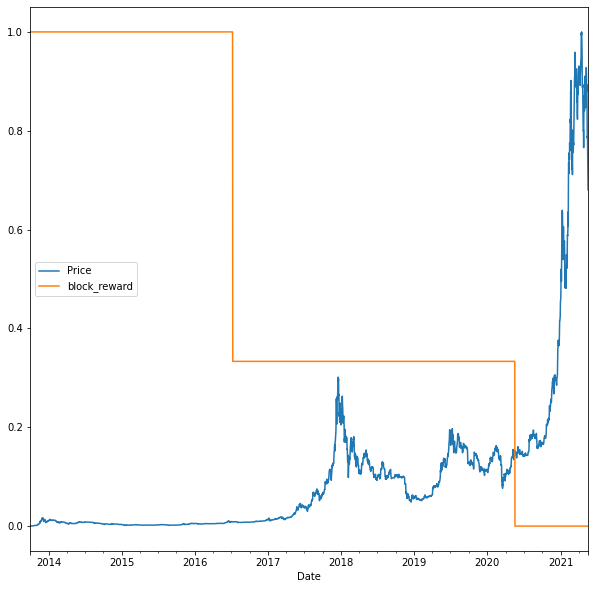

In [99]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                                                       columns=bitcoin_prices_block.columns,
                                                                       index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10,10))

## Making a windowed dataset winth pandas

Previously, we've turned our univariate time eseries into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the pandas.DataFrame.shift() method to window our multivariate data.

In [100]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [101]:
# Make a copy of the bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is create a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[ 1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [102]:
# Create X (windows) and y (horizons) features
x = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

In [103]:
x.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [104]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [105]:
# Make train an test sets using indexing
split_size = int(len(x)*0.8)
x_train, y_train = x[:split_size], y[:split_size]
x_test, y_test = x[split_size:], y[split_size:]

len(x_train), len(y_train), len(x_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

In [106]:
# Make multivariate time series model
model_1.summary() # compare base with model 1

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1024      
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,153
Trainable params: 1,153
Non-trainable params: 0
_________________________________________________________________


In [109]:
# Make multivariate time series model
model_6 = tf.keras.Sequential([
                               layers.Dense(128, activation="relu"),
                               layers.Dense(128, activation="relu"),
                               layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

In [111]:
model_6.fit(x_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=1,
            validation_data=(x_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
17/18 [===========================>..] - ETA: 0s - loss: 1561.8273INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 2s 60ms/step - loss: 1537.3694 - val_loss: 1653.0455
Epoch 2/100
15/18 [========================>.....] - ETA: 0s - loss: 318.1632INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 49ms/step - loss: 308.1770 - val_loss: 1170.8402
Epoch 3/100
18/18 [==============================] - 0s 7ms/step - loss: 221.3277 - val_loss: 1443.8743
Epoch 4/100
15/18 [========================>.....] - ETA: 0s - loss: 192.4839INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 50ms/step - loss: 190.1277 - val_loss: 1000.3667
Epoch 5/100
17/18 [===========================>..] - ETA: 0s - loss: 165.0402INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 49ms/step - loss: 163.6042 - val_loss: 877.7004
Epoch 6/100
14/18 [======================>.......] - ETA: 0s - loss: 145.2154INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 70ms/step - loss: 144.3452 - val_loss: 742.4996
Epoch 7/100
18/18 [==============================] - 0s 7ms/step - loss: 131.2487 - val_loss: 789.8508
Epoch 8/100
16/18 [=========================>....] - ETA: 0s - loss: 124.3380INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 52ms/step - loss: 122.9365 - val_loss: 642.2186
Epoch 9/100
15/18 [========================>.....] - ETA: 0s - loss: 117.8525INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 52ms/step - loss: 119.8044 - val_loss: 614.2115
Epoch 10/100
18/18 [==============================] - 0s 6ms/step - loss: 130.8928 - val_loss: 843.8468
Epoch 11/100
18/18 [==============================] - 0s 6ms/step - loss: 130.5978 - val_loss: 1193.9899
Epoch 12/100
15/18 [========================>.....] - ETA: 0s - loss: 141.6223INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 52ms/step - loss: 140.7176 - val_loss: 596.0994
Epoch 13/100
16/18 [=========================>....] - ETA: 0s - loss: 113.6168INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 51ms/step - loss: 113.4609 - val_loss: 593.5816
Epoch 14/100
18/18 [==============================] - 0s 7ms/step - loss: 112.2461 - val_loss: 602.9174
Epoch 15/100
17/18 [===========================>..] - ETA: 0s - loss: 127.8573INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 51ms/step - loss: 128.3448 - val_loss: 590.1117
Epoch 16/100
18/18 [==============================] - 0s 7ms/step - loss: 114.1822 - val_loss: 645.8589
Epoch 17/100
15/18 [========================>.....] - ETA: 0s - loss: 118.6824INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 53ms/step - loss: 121.0298 - val_loss: 580.3873
Epoch 18/100
18/18 [==============================] - 0s 6ms/step - loss: 124.1520 - val_loss: 607.0169
Epoch 19/100
18/18 [==============================] - 0s 6ms/step - loss: 115.0710 - val_loss: 582.1490
Epoch 20/100
16/18 [=========================>....] - ETA: 0s - loss: 110.1882INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 51ms/step - loss: 110.7586 - val_loss: 575.1353
Epoch 21/100
18/18 [==============================] - 0s 6ms/step - loss: 110.8415 - val_loss: 610.3167
Epoch 22/100
17/18 [===========================>..] - ETA: 0s - loss: 113.0836INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 52ms/step - loss: 113.3307 - val_loss: 571.7591
Epoch 23/100
18/18 [==============================] - 0s 7ms/step - loss: 115.4288 - val_loss: 577.2100
Epoch 24/100
18/18 [==============================] - 0s 7ms/step - loss: 111.0399 - val_loss: 591.7221
Epoch 25/100
17/18 [===========================>..] - ETA: 0s - loss: 109.8693INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 50ms/step - loss: 109.5301 - val_loss: 568.2144
Epoch 26/100
17/18 [===========================>..] - ETA: 0s - loss: 108.3339INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 52ms/step - loss: 108.5212 - val_loss: 567.1038
Epoch 27/100
18/18 [==============================] - 0s 6ms/step - loss: 106.4838 - val_loss: 574.3896
Epoch 28/100
18/18 [==============================] - 0s 7ms/step - loss: 108.5501 - val_loss: 598.0718
Epoch 29/100
18/18 [==============================] - 0s 6ms/step - loss: 108.0007 - val_loss: 612.4135
Epoch 30/100
18/18 [==============================] - 0s 7ms/step - loss: 113.6695 - val_loss: 674.6104
Epoch 31/100
18/18 [==============================] - 0s 6ms/step - loss: 119.9902 - val_loss: 567.1916
Epoch 32/100
15/18 [========================>.....] - ETA: 0s - loss: 109.0314INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 49ms/step - loss: 107.5165 - val_loss: 566.1949
Epoch 33/100
18/18 [==============================] - 0s 7ms/step - loss: 106.7531 - val_loss: 587.3987
Epoch 34/100
18/18 [==============================] - 0s 6ms/step - loss: 108.2009 - val_loss: 725.8928
Epoch 35/100
18/18 [==============================] - 0s 6ms/step - loss: 112.2972 - val_loss: 656.0472
Epoch 36/100
18/18 [==============================] - 0s 14ms/step - loss: 117.5482 - val_loss: 585.0856
Epoch 37/100
18/18 [==============================] - 0s 13ms/step - loss: 115.4308 - val_loss: 578.3851
Epoch 38/100
18/18 [==============================] - ETA: 0s - loss: 111.1893INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 85ms/step - loss: 111.1893 - val_loss: 563.3354
Epoch 39/100
18/18 [==============================] - 0s 9ms/step - loss: 108.5170 - val_loss: 615.2319
Epoch 40/100
18/18 [==============================] - 0s 9ms/step - loss: 112.9117 - val_loss: 576.2380
Epoch 41/100
18/18 [==============================] - 0s 7ms/step - loss: 110.0444 - val_loss: 569.0483
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 115.6700 - val_loss: 702.4159
Epoch 43/100
18/18 [==============================] - 0s 6ms/step - loss: 118.5857 - val_loss: 621.9826
Epoch 44/100
18/18 [==============================] - 0s 10ms/step - loss: 106.4545 - val_loss: 563.9272
Epoch 45/100
18/18 [==============================] - 0s 14ms/step - loss: 105.2038 - val_loss: 564.3416
Epoch 46/100
18/18 [==============================] - 0s 13ms/step - loss: 110.5550 - val_loss: 748.3533
Epoch 47/100
18/18 [==============================] - 0s 10ms/step - loss

INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets


18/18 [==============================] - 1s 53ms/step - loss: 108.4287 - val_loss: 560.8259
Epoch 52/100
18/18 [==============================] - 0s 7ms/step - loss: 114.8579 - val_loss: 612.6434
Epoch 53/100
18/18 [==============================] - 0s 7ms/step - loss: 114.9368 - val_loss: 645.1370
Epoch 54/100
18/18 [==============================] - 0s 7ms/step - loss: 111.5091 - val_loss: 660.7234
Epoch 55/100
18/18 [==============================] - 0s 7ms/step - loss: 113.0833 - val_loss: 635.4078
Epoch 56/100
18/18 [==============================] - 0s 7ms/step - loss: 105.7487 - val_loss: 644.6835
Epoch 57/100
18/18 [==============================] - 0s 7ms/step - loss: 106.6330 - val_loss: 587.7735
Epoch 58/100
18/18 [==============================] - 0s 7ms/step - loss: 106.0572 - val_loss: 577.6873
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 105.6658 - val_loss: 603.5469
Epoch 60/100
18/18 [==============================] - 0s 6ms/step - loss: 11

### Make prediction and evaluate

In [ ]:
# Evaluate the model
model_6.evaluate(x_test, y_test)

In [112]:
# Load the best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(x_test, y_test)

18/18 [==============================] - 0s 5ms/step - loss: 560.8259


560.825927734375

In [114]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(x_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8791.969, 8754.409, 9002.355, 8737.593, 8746.373, 8680.023,
       8642.798, 8517.572, 8411.618, 8506.002], dtype=float32)>

In [115]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 560.8259,
 'mape': 2.5252552,
 'mase': 0.98521584,
 'mse': 1137040.4,
 'rmse': 1066.3209}

In [116]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171744.0,
 'rmse': 1082.4712}

In [120]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## ✍️ Course Content 330 - 331 
Tensorflow Cetrtificate

## Model 7: N-BEATS

Let's try build the biggest time series forecasting model we've built sofar.

More specifically, we're going to be replicating the algorithm in the following paper (figure 1): https://arxiv.org/pdf/1905.10437.pdf

* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture
* Potentially get state of the art results on our problem

Custom layers and models: https://www.tensorflow.org/tutorials/customization/custom_layers



### Create NBeatsBlock class

In [133]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs):
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connect layers each has ReLU activation
    self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu", name=f"hidden_{1}") for i in range(n_layers)] # Create the hidden layers by number of n_layers

    # Output of block is a theta layer
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    theta = self.theta_layer(x)
    
    # Output the backcast and the forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast


### Test NBeatsBlock class with Dummy

Make some dummy inputs and outputs

In [134]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON,
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4) # backcast + forecast

In [136]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) +1, axis=0) # input shape to the model has to reflect dense layer input requirements (ndim=2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [140]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)

# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Backcast: {tf.squeeze(backcast.numpy())}")
print(f"Forecast: {tf.squeeze(forecast.numpy())}")

Backcast: [ 0.15632057  0.37564403 -0.32300907  0.23842326  0.2613251  -0.68667954
 -0.31051293]
Forecast: 0.1570146381855011
